# Project 3 
## Goal(s):

Predict how fit the candidate is based on their available information (variable fit)

## Success Metric(s):

Rank candidates based on a fitness score.

Re-rank candidates when a candidate is starred.

## Bonus(es):

We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.

How can we filter out candidates which in the first place should not be in this list?

Can we determine a cut-off point that would work for other roles without losing high potential candidates?

Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

Note: with help from https://www.kaggle.com/code/niklasdonges/end-to-end-project-with-python

In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb


#Cross validation
from sklearn.model_selection import KFold, cross_val_score

#Other
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#class imbalance
from sklearn.metrics import f1_score
from sklearn.utils import resample

#embedding using BERT

from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity


# Loading data

In [2]:
og_data = pd.read_excel('potential-talents.xlsx')
data = og_data
keywords = 'aspiring human resources'

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [4]:
data.columns

Index(['id', 'job_title', 'location', 'connection', 'fit'], dtype='object')

In [6]:
data.describe()

,id,fit
count,104.000000,0.0
mean,52.500000,NaN
std,30.166206,NaN
min,1.000000,NaN
25%,26.750000,NaN
50%,52.500000,NaN
75%,78.250000,NaN
max,104.000000,NaN


In [7]:
data.head(15)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,9,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN


Attributes:
id : unique identifier for candidate (numeric)

job_title : job title for candidate (text)

location : geographical location for candidate (text)

connections: number of connections candidate has, 500+ means over 500 (text)

In [8]:
print('title: ', data.job_title.unique())
print('location: ', data.location.unique())
print('connections: ', data.connection.unique())

title:  ['2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional'
 'Native English Teacher at EPIK (English Program in Korea)'
 'Aspiring Human Resources Professional'
 'People Development Coordinator at Ryan'
 'Advisory Board Member at Celal Bayar University'
 'Aspiring Human Resources Specialist'
 'Student at Humber College and Aspiring Human Resources Generalist'
 'HR Senior Specialist'
 'Seeking Human Resources HRIS and Generalist Positions'
 'Student at Chapman University'
 'SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR'
 'Human Resources Coordinator at InterContinental Buckhead Atlanta'
 'Aspiring Human Resources Management student seeking an internship'
 'Seeking Human Resources Opportunities'
 'Experienced Retail Manager and aspiring Human Resources Professional'
 'Human Resources, Staffing and Recruiting Professional'
 'Human Resources Specialist at Luxottica'
 'Dire

# Processing data

In [9]:
#First we will normalize the connections to be between 0-1. We will count 500+ as 500

# Function to normalize scores to between 0-1
def normalize_score(score):
    if score == '500+ ':
        score = 500
    return float(score)/500

# Applying the function to the 'connection' column to create a new 'normalized_connections' column
data['normalized_connections'] = data['connection'].apply(normalize_score)


In [10]:
#We will then calculate the similarity between the job titles and the given keyword (stored as variable 'keywords' in the top of the code, at first it we use 'aspiring human resources')

# Load the BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Tokenize and encode the job titles using BERT
job_title_encodings = data["job_title"].apply(
    lambda title: model(**tokenizer(title, return_tensors="pt")).pooler_output.detach().numpy()
)

# Compute the cosine similarity between the encoded job titles and the keyword
keyword_encoding = model(**tokenizer(keywords, return_tensors="pt")).pooler_output.detach().numpy()
similarity_scores = np.vstack(job_title_encodings.apply(lambda encoding: cosine_similarity(encoding, keyword_encoding))).ravel()

# Add the similarity scores as a new column in the DataFrame
data["similarity_score"] = similarity_scores


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
data.head()

,id,job_title,location,connection,fit,normalized_connections,similarity_score
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,0.170,0.764336
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,1.000,0.899860
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.088,0.937843
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,1.000,0.824166


In [13]:
#now make a new column fitness score based on an equation taking similarity_score and normalized_connections

# calculate the new column based on the equation
data['fitness_score'] = data['similarity_score'] * 0.8 + data['normalized_connections'] * 0.2
data = data.sort_values(by='fitness_score', ascending=False)


,id,job_title,location,connection,fit,normalized_connections,similarity_score,fitness_score
58,59,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.0,0.984712,0.98777
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.0,0.984712,0.98777
46,47,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.0,0.984712,0.98777
33,34,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.0,0.984712,0.98777
21,22,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.0,0.984712,0.98777


# Starring candidates

In [41]:
# add a new column named 'starred' and set all values to 0
data['starred'] = 0

# set the value of the 7th row in 'starred' to 1 as an example
data.loc[6, 'starred'] = 1

#update the fitness_score based on starring
data['fitness_score'] = data['similarity_score'] * 0.8 + data['normalized_connections'] * 0.2 + data['starred']
data = data.sort_values(by='fitness_score', ascending=False)
# print the updated dataframe
data.head()


,id,job_title,location,connection,fit,normalized_connections,similarity_score,fitness_score,starred,new_fitness_score
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN,0.122,0.860559,1.712847,1,-4.509048
21,22,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,0.987770,0,-4.807892
58,59,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,0.987770,0,-4.807892
17,18,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,0.987770,0,-4.807892
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,0.987770,0,-4.807892


In [42]:
# set the value of the 7th row in 'starred' to 1 as second an example
data.loc[3, 'starred'] = 1

#update the fitness_score based on starring
data['fitness_score'] = data['similarity_score'] * 0.8 + data['normalized_connections'] * 0.2 + data['starred']
data = data.sort_values(by='fitness_score', ascending=False)
# print the updated dataframe
data.head()

,id,job_title,location,connection,fit,normalized_connections,similarity_score,fitness_score,starred,new_fitness_score
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,1.987770,1,-4.807892
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN,0.122,0.860559,1.712847,1,-4.509048
21,22,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,0.987770,0,-4.807892
58,59,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,0.987770,0,-4.807892
17,18,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,0.987770,0,-4.807892


# Make X and Y

In [50]:
feature_cols = ['normalized_connections', 'similarity_score']
X = data[feature_cols]
y = data.starred 

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# Make sure at least one example of data with positive supervisory signal is in the training set
if y_train.sum() == 0:
    print('add')
    # Find the index of the first positive example
    index_of_positive = (y == 1).idxmax()
    # Add the positive example to the training set
    X_train.append(X.loc[index_of_positive])
    y_train.append(y.loc[index_of_positive])

Accuracy 1.0
F1 Score: 0.00

Logistic regression equation: y = 0.04*x1 + 0.07*x2 + -1.82


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


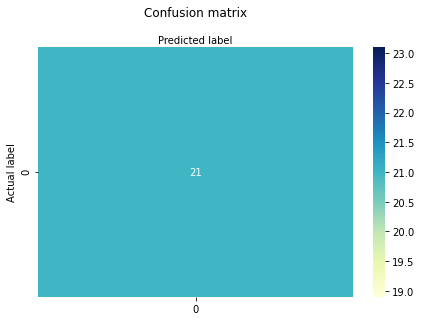

In [72]:

# Train a logistic regression model
model = LogisticRegression(class_weight={0: 0.1, 1: 0.9})
model.fit(X,y)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy', accuracy)
f1 = f1_score(y_test, y_pred, pos_label=1)
print(f"F1 Score: {f1:.2f}\n")

# Print the coefficients of the logistic regression equation
print('Logistic regression equation: y = {:.2f}*x1 + {:.2f}*x2 + {:.2f}'.format(model.coef_[0][0], model.coef_[0][1], model.intercept_[0]))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
plot = True
if plot:
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()



This code will print out the coefficients of the logistic regression equation in the form y = b1x1 + b2x2 + b0, where b1 and b2 are the coefficients for the 'normalized_connections' and 'similarity_score' columns, respectively, and b0 is the intercept.

# Updating fitness and ranking

In [73]:
#rank based on probabilities

data['probabilities'] = model.predict_proba(data[feature_cols])[:, 1]
data = data.sort_values(by='probabilities', ascending=False)
data.head()

,id,job_title,location,connection,fit,normalized_connections,similarity_score,fitness_score,starred,new_fitness_score,probabilities
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.0,0.984712,1.98777,1,-3.898143,0.153457
58,59,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.0,0.984712,0.98777,0,-3.898143,0.153457
17,18,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.0,0.984712,0.98777,0,-3.898143,0.153457
33,34,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.0,0.984712,0.98777,0,-3.898143,0.153457
46,47,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.0,0.984712,0.98777,0,-3.898143,0.153457


Problem: I am not seeing my second starred row at the top of the list

In [74]:
#rank based on new fitness function
#update the fitness_score based on logistic regression coefficients
data['fitness_score'] = data['similarity_score'] * model.coef_[0][1] + data['normalized_connections'] * model.coef_[0][0] + data['starred']
data = data.sort_values(by='fitness_score', ascending=False)
# print the updated dataframe
data.head()

,id,job_title,location,connection,fit,normalized_connections,similarity_score,fitness_score,starred,new_fitness_score,probabilities
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,1.111317,1,-3.898143,0.153457
6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN,0.122,0.860559,1.065461,1,-3.954231,0.147594
46,47,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,0.111317,0,-3.898143,0.153457
21,22,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,0.111317,0,-3.898143,0.153457
58,59,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,1.000,0.984712,0.111317,0,-3.898143,0.153457


## Result for ranking

I have ranked candidates based on a fitness score that incorporates cosine similarity and normalized connections. I then rerank if someone manually stars a candidate.
I then built a logisitic regression model with class weights to train on the data with the y='starred' and reranked the data based on the probabilities obtained.
However I then see that my previously starred candidates don't all appear at the top of the new ranking as the model didn't train well on such a small positive class (n=2).
I also tried reranking based on a new fitness equation that takes into account the log reg coefficients. Not sure whats best.